In [1]:
import os
os.chdir("C:\\Users\\zxpay\\Desktop\\BME_Senior\\EEG_CLF\\Emotion\\Code")
import sys
from Get_file import Get_file   # return dirpath, dirnames, filenames
from FFT import FFT
import pyedflib
import numpy as np
from scipy.signal import butter, lfilter
from scipy.signal import freqz
import matplotlib.pyplot as plt

# Setting parameters
Sample_frequency = 128
DEBUG = True
label_size = 40
channel_we_use = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]   # 0~39 共40


In [2]:
#Four Lables
normal_lable = []   # 0
scare_lable = []    # 1
touch_lable = []    # 2
laugh_lable = []    # 3

#Four Signal
normal_signal = []
scare_signal = []
touch_signal = []
laugh_signal = []

signal = []
labels = []

data_path = "C:\\Users\\zxpay\\Desktop\\BME_Senior\\EEG_CLF\\Emotion\\database"

_,data_files,_ = Get_file(data_path)
if data_files == []:
    raise("Not found any files ! check your data_path")
else:
    print('Get data from database ...')
    for data in data_files:
        _,_,file_names = Get_file(data_path+'\\'+data)
        for fn in file_names:
            if fn.split('.')[1] == 'edf':
                if DEBUG:
                    #print(data_path+'\\'+data+'\\'+fn)
                    pass
                fedf = pyedflib.EdfReader(data_path+'\\'+data+'\\'+fn)
                n = fedf.signals_in_file
                signal_labels = np.asarray(fedf.getSignalLabels())
                sigbufs = np.zeros((n, fedf.getNSamples()[0]))
                for i in np.arange(n):
                    sigbufs[i, :] = fedf.readSignal(i)

                if 'normal' in fn:
                    normal_lable.append(0)
                    normal_signal.append(sigbufs)
                elif 'scare' in fn:
                    scare_lable.append(1)
                    scare_signal.append(sigbufs)
                elif 'touch' in fn:
                    touch_lable.append(2)
                    touch_signal.append(sigbufs)
                elif 'laugh' in fn:
                    laugh_lable.append(3)
                    laugh_signal.append(sigbufs)
                    
                if DEBUG:
                    print(sigbufs.shape)

''' Labels --> 40 channels
['COUNTER' 'INTERPOLATED' 'AF3' 'F7' 'F3' 'FC5' 'T7' 'P7' 'O1' 'O2' 'P8'
 'T8' 'FC6' 'F4' 'F8' 'AF4' 'RAW_CQ' 'GYROX' 'GYROY' 'MARKER'
 'MARKER_HARDWARE' 'SYNC' 'TIME_STAMP_s' 'TIME_STAMP_ms' 'CQ_AF3' 'CQ_F7'
 'CQ_F3' 'CQ_FC5' 'CQ_T7' 'CQ_P7' 'CQ_O1' 'CQ_O2' 'CQ_P8' 'CQ_T8' 'CQ_FC6'
 'CQ_F4' 'CQ_F8' 'CQ_AF4' 'CQ_CMS' 'CQ_DRL']
'''

print('Okay')
if DEBUG:
    print('normal signal length : ', len(normal_signal))
    print('scare signal length : ', len(scare_signal))
    print('touch signal length : ', len(touch_signal))
    print('laugh signal length : ', len(laugh_signal))



Get data from database ...
(40, 38400)
(40, 105344)
(40, 38400)
(40, 105344)
(40, 179328)
(40, 309248)
(40, 38400)
(40, 179328)
(40, 309760)
(40, 38400)
(40, 105728)
(40, 158976)
(40, 58112)
(40, 50944)
(40, 33152)
(40, 3968)
(40, 38400)
(40, 105344)
(40, 178944)
(40, 308992)
(40, 38400)
(40, 105728)
(40, 179840)
(40, 237312)
(40, 38400)
(40, 105600)
(40, 179584)
(40, 38400)
(40, 178944)
(40, 308864)
(40, 38400)
(40, 105344)
(40, 179072)
(40, 83328)
(40, 117632)
(40, 107392)
(40, 38400)
(40, 308992)
(40, 38400)
(40, 179072)
(40, 105344)
(40, 308736)
(40, 38400)
(40, 313472)
(40, 38400)
(40, 105344)
(40, 38400)
(40, 105344)
(40, 38528)
(40, 179200)
(40, 308736)
(40, 38400)
(40, 179328)
(40, 38400)
(40, 105344)
Okay
normal signal length :  17
scare signal length :  11
touch signal length :  10
laugh signal length :  17


In [3]:
# Band pass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Lowpass filter
def butter_lowpass(cutOff, fs, order=5):
    nyq = 0.5 * fs
    normalCutoff = cutOff / nyq
    b, a = butter(order, normalCutoff, btype='low', analog = True)
    return b, a

def butter_lowpass_filter(data, cutOff, fs, order=4):
    b, a = butter_lowpass(cutOff, fs, order=order)
    y = lfilter(b, a, data)
    return y

(64,)
(64,)


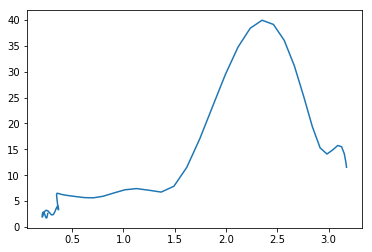

In [8]:
# Split the data from each channel
def Get_signal(raw_data, channel, sample_freq=128):
    times = int(raw_data.shape[1]/Sample_frequency)
    datai = []
    signal_alpha = []
    signal_beta = []
    num_sp = 0
    for i in range(times):
        datai.append(raw_data[channel][num_sp:(num_sp+sample_freq)])
        num_sp += sample_freq

    for x in datai:
        alpha = butter_bandpass_filter(x,8,12,Sample_frequency)
        alpha = alpha[8:13]
        beta = butter_bandpass_filter(x,13,30,Sample_frequency)
        beta = beta[13:31]
        freq_alpha, data_alpha = FFT(alpha, Sample_frequency, Sample_frequency)
        freq_bata, data_beta = FFT(beta, Sample_frequency, Sample_frequency)
        signal_alpha.append(data_alpha)
        signal_beta.append(data_beta)
        
    alpha_mean = np.asarray(signal_alpha)
    alpha_mean = np.mean(alpha_mean, 0)
    beta_mean = np.asarray(signal_beta)
    beta_mean = np.mean(beta_mean, 0)
    return alpha_mean, beta_mean
# example
x = np.linspace(0,1,64)
a, b = Get_signal(scare_signal[4], 14, 128)   # each data samples is 64
if DEBUG:
    print(a.shape)
    print(b.shape)
plt.plot(a,b)
plt.show()

In [15]:
# Get all normal signal data
# Data shape : 64 X 14 X person_numbers       ， 14 is 14 channels
normal_alpha = np.zeros([64,14,len(normal_signal)], dtype=np.float32)
normal_beta = np.zeros([64,14,len(normal_signal)], dtype=np.float32)
ch_num = 0
for i in range(len(normal_signal)):
    for ch in range(label_size):
        if ch in channel_we_use:
            delta_a, delta_b = Get_signal(normal_signal[i], ch, Sample_frequency)
            normal_alpha[:,ch_num,i] = delta_a
            normal_beta[:,ch_num,i] = delta_b
            ch_num += 1
            print('CH:', ch)
            print(delta_a)
            print()
#             x = np.linspace(0,1,64)
#             plt.plot(x, delta_a, 'r')
#             plt.show()
#             plt.plot(x, delta_b, 'b')
#             plt.show()
    ch_num = 0  

CH: 2
[3.17285959 3.16745304 3.15127363 3.12444173 3.08715682 3.03969584
 2.98241084 2.91572607 2.84013448 2.75619361 2.66452114 2.56578988
 2.46072249 2.35008588 2.23468553 2.11535966 1.99297352 1.86841396
 1.74258444 1.61640077 1.4907879  1.36667826 1.24501222 1.12674138
 1.01283571 0.90429551 0.80216878 0.70757299 0.62171576 0.54589777
 0.48146118 0.4296219  0.39113006 0.36580984 0.35223584 0.34786225
 0.3496038  0.35449783 0.36011574 0.36467962 0.36700538 0.36638923
 0.36249767 0.35528084 0.3449102  0.33173659 0.31626371 0.29913283
 0.28111438 0.26310049 0.24608746 0.23113023 0.21924588 0.21125447
 0.20758773 0.20815319 0.21234381 0.21919716 0.22761268 0.23652977
 0.24502907 0.25237071 0.25799731 0.26152343]

CH: 3
[3.17292207 3.16751558 3.15133636 3.12450477 3.08722029 3.03975986
 2.98247552 2.91579154 2.84020083 2.75626096 2.6645896  2.56585954
 2.46079344 2.35015823 2.23475938 2.1154351  1.99305066 1.86849292
 1.74266536 1.61648378 1.49087317 1.36676599 1.24510266 1.12683481
 1.

CH: 14
[3.1718806  3.1664758  3.15030162 3.12347838 3.08620551 3.03875986
 2.98149337 2.91483017 2.83926303 2.75534934 2.66370658 2.56500735
 2.45997408 2.34937346 2.23401072 2.11472382 1.99237776 1.86785913
 1.74207112 1.61592928 1.4903583  1.36629037 1.24466561 1.12643538
 1.01256943 0.90406783 0.8019783  0.70741806 0.62159435 0.5458073
 0.48139826 0.42958207 0.39110759 0.36579811 0.35222828 0.34785352
 0.34959049 0.35447845 0.36009029 0.36464906 0.36697125 0.36635333
 0.36246194 0.3552472  0.34488049 0.33171254 0.31624688 0.29912451
 0.28111558 0.26311179 0.24610882 0.23116078 0.2192838  0.21129695
 0.20763131 0.2081944  0.21237984 0.21922623 0.22763408 0.23654366
 0.24503624 0.25237236 0.25799486 0.26151849]

CH: 15
[3.17302648 3.16761959 3.15143914 3.12460552 3.08731823 3.03985422
 2.98256556 2.91587653 2.8402801  2.75633387 2.66465554 2.56591796
 2.46084383 2.35020014 2.23479238 2.11545884 1.99306482 1.86849722
 1.74265955 1.61646766 1.49084657 1.36672874 1.2450546  1.12677578
 1

CH: 12
[3.17407171 3.16866326 3.15247815 3.1256368  3.08833876 3.04086107
 2.9835559  2.91684767 2.84122948 2.7572591  2.66555441 2.56678847
 2.46168419 2.35100879 2.23556803 2.11620043 1.99377158 1.86916865
 1.74329547 1.61706817 1.49141209 1.36726004 1.24555276 1.12724228
 1.01329897 0.90472356 0.80256449 0.70793967 0.62205708 0.54621763
 0.48176342 0.4299099  0.39140632 0.36607592 0.35249271 0.34811091
 0.34984555 0.35473412 0.36034793 0.36490876 0.36723219 0.36661409
 0.36272079 0.35550229 0.34513003 0.33195493 0.31648081 0.29934908
 0.28133032 0.26331673 0.24630452 0.23134827 0.21946449 0.21147248
 0.20780345 0.20836494 0.2125505  0.2193985  0.22780908 0.23672202
 0.24521812 0.25255746 0.25818253 0.2617078 ]

CH: 13
[3.17058658 3.16518401 3.14901651 3.12220436 3.08494691 3.03752087
 2.98027805 2.9136424  2.83810648 2.75422745 2.66262253 2.56396404
 2.4589741  2.34841908 2.23310388 2.1138661  1.99157038 1.86710293
 1.74136656 1.61527644 1.48975685 1.3657396  1.2441644  1.1259822
 1

CH: 10
[3.17581379 3.17040238 3.15420839 3.12735232 3.09003384 3.04253011
 2.98519353 2.91844873 2.84278909 2.75877268 2.66701773 2.56819767
 2.46303581 2.35229978 2.2367958  2.11736284 1.99486698 1.87019588
 1.74425386 1.61795757 1.49223285 1.36801304 1.24623941 1.1278645
 1.01385925 0.90522496 0.80301062 0.7083348  0.62240614 0.54652624
 0.48203789 0.43015711 0.39163339 0.3662897  0.35269918 0.34831468
 0.35004968 0.35494019 0.3605563  0.36511889 0.3674429  0.36682387
 0.36292791 0.35570502 0.34532674 0.33214417 0.3166614  0.29952021
 0.28149162 0.2634683  0.246447   0.23148286 0.21959288 0.21159674
 0.20792586 0.20848767 0.21267542 0.21952699 0.22794198 0.23685962
 0.24536021 0.25270345 0.25833151 0.26185866]

CH: 11
[3.18005843 3.1746399  3.15842464 3.13153329 3.09416577 3.04659963
 2.98918772 2.92235522 2.84659616 2.76246935 2.67059383 2.5716439
 2.46634384 2.35546228 2.2398065  2.12021658 1.99755973 1.87272478
 1.74661725 1.62015501 1.49426512 1.36988215 1.24794863 1.12941835
 1.

CH: 8
[3.16105007 3.15566399 3.13954582 3.11281548 3.07567171 3.02839038
 2.97132222 2.90488988 2.82958443 2.74596132 2.6546359  2.55627842
 2.45160882 2.34139113 2.22642779 2.10755386 1.98563135 1.86154378
 1.73619123 1.61048608 1.48534985 1.3617115  1.24050792 1.12268721
 1.00921577 0.90109018 0.79935455 0.7051221  0.61959569 0.54407056
 0.47988283 0.42824229 0.38989451 0.36466321 0.35112876 0.3467569
 0.34847651 0.35333814 0.35892349 0.36346178 0.36577337 0.36515692
 0.36127995 0.35409254 0.3437653  0.33064758 0.31524103 0.29818426
 0.28024455 0.26231014 0.24537277 0.23048216 0.21864999 0.21069159
 0.2070361  0.20759156 0.21175459 0.21856829 0.22693808 0.23580864
 0.24426489 0.25157013 0.25716924 0.26067831]

CH: 9
[3.15678019 3.15140177 3.13530652 3.10861421 3.07152326 3.02430917
 2.96732217 2.90098431 2.82578594 2.74228174 2.65108615 2.55286851
 2.44834772 2.33828672 2.22348682 2.1047819  1.98303275 1.85912167
 1.73394746 1.60842124 1.48346324 1.36000116 1.23897058 1.12131829
 1.0

CH: 6
[3.1603268  3.15494171 3.13882653 3.11210114 3.07496425 3.02769167
 2.97063408 2.90421405 2.82892255 2.74531494 2.65400643 2.55566716
 2.45101694 2.34081965 2.22587756 2.10702558 1.98512555 1.8610608
 1.73573123 1.61004903 1.48493551 1.36131944 1.24013749 1.12233752
 1.00888572 0.90077847 0.79905965 0.70484232 0.6193293  0.54381593
 0.47963869 0.42800806 0.3896704  0.36444996 0.35092692 0.3465662
 0.34829574 0.35316546 0.35875694 0.36329952 0.36561389 0.36499899
 0.36112261 0.353935   0.34360689 0.33048771 0.31507911 0.29801977
 0.28007699 0.26213921 0.24519846 0.230305   0.21847123 0.21051319
 0.20686043 0.20742085 0.21159039 0.21841124 0.22678796 0.23566469
 0.24412605 0.25143523 0.25703711 0.26054782]

CH: 7
[3.16262989 3.15724084 3.1411138  3.11436874 3.07720452 3.02989716
 2.97279759 2.9063287  2.83098181 2.74731271 2.65593706 2.55752551
 2.45279837 2.34252012 2.22749362 2.10855438 1.9865649  1.86240916
 1.73698773 1.61121348 1.48600841 1.36230198 1.24103155 1.12314573
 1.00

CH: 4
[3.1651329  3.15973956 3.1435997  3.11683337 3.07963959 3.03229461
 2.97514963 2.90862785 2.83322102 2.74948533 2.65803694 2.55954702
 2.45473646 2.34437031 2.22925209 2.11021796 1.98813107 1.86387611
 1.73835434 1.61247934 1.48717381 1.36336793 1.24199978 1.12401865
 1.01039219 0.90211827 0.80024235 0.7058792  0.62023347 0.54460262
 0.48032533 0.42861426 0.39021727 0.36495864 0.35141639 0.34705127
 0.34878603 0.35366569 0.35926783 0.363819   0.36613803 0.3655228
 0.36164063 0.35444171 0.34409709 0.33095673 0.3155231  0.29843587
 0.28046358 0.26249613 0.24552722 0.23060895 0.21875557 0.21078468
 0.20712667 0.20768929 0.21186732 0.21870113 0.22709328 0.23598602
 0.24446242 0.25178446 0.25739613 0.26091294]

CH: 5
[3.16630052 3.16090527 3.14475968 3.11798385 3.08077688 3.03341509
 2.97624983 2.90970446 2.83427087 2.75050548 2.65902466 2.56049981
 2.45565209 2.34524684 2.23008783 2.11101156 1.98888147 1.86458258
 1.73901648 1.61309709 1.48774745 1.36389808 1.24248743 1.12446516
 1.0

CH: 2
[3.17789495 3.1724798  3.15627466 3.12940008 3.09205587 3.0445194
 2.98714328 2.92035245 2.84464061 2.76056622 2.66874792 2.56985959
 2.46462502 2.35381238 2.23822839 2.1187126  1.99613165 1.87137379
 1.7453439  1.61895924 1.49314622 1.36883876 1.24697869 1.12851911
 1.01443154 0.90571783 0.80342762 0.70868017 0.62268503 0.54674498
 0.48220441 0.43028137 0.39172742 0.36636671 0.35277166 0.34839227
 0.35013812 0.35504156 0.36066996 0.36524249 0.36757316 0.36695702
 0.36306008 0.35583239 0.3454457  0.33225143 0.31675409 0.29959596
 0.28154871 0.26350592 0.24646549 0.23148408 0.2195805  0.21157617
 0.20790359 0.20847015 0.21266784 0.21953258 0.22796201 0.23689377
 0.24540701 0.25276067 0.25839645 0.26192834]

CH: 3
[3.17519285 3.16978242 3.1535914  3.12674024 3.08942857 3.04193352
 2.98460741 2.91787479 2.84222894 2.75822784 2.66648958 2.56768748
 2.4625447  2.35182873 2.23634561 2.11693418 1.99446031 1.8698115
 1.74389188 1.61761792 1.49191524 1.36771699 1.24596423 1.12760927
 1.01

CH: 14
[3.17557136 3.17016023 3.15396712 3.12711248 3.08979598 3.04229479
 2.98496126 2.91822    2.84256436 2.75855239 2.66680226 2.56798738
 2.46283099 2.35210069 2.23660262 2.11717572 1.99468599 1.87002102
 1.74408506 1.61779469 1.49207566 1.36786122 1.24609253 1.12772204
 1.01372056 0.90508927 0.80287706 0.7082024  0.62227393 0.54639338
 0.48190392 0.43002228 0.39149889 0.36615753 0.3525715  0.34819305
 0.34993464 0.35483142 0.36045296 0.36501992 0.36734726 0.36673058
 0.36283609 0.35561387 0.34523552 0.33205216 0.31656793 0.2994246
 0.28139325 0.26336666 0.24634184 0.23137434 0.21948179 0.21148454
 0.20781445 0.20837895 0.21257083 0.21942723 0.22784707 0.23676912
 0.24527342 0.25261954 0.25824966 0.26177803]

CH: 15
[3.17670008 3.17128707 3.15508835 3.12822442 3.09089501 3.04337737
 2.98602399 2.91925963 2.84357779 2.75953672 2.66775482 2.56890569
 2.46371287 2.35294418 2.23740607 2.11793774 1.9954055  1.87069727
 1.74471757 1.61838332 1.49262059 1.36836293 1.24655186 1.12814011
 1

CH: 12
[3.17038171 3.16497964 3.14881364 3.12200398 3.08474997 3.03732833
 2.98009082 2.91346133 2.8379324  2.75406112 2.66246466 2.56381527
 2.45883501 2.34829018 2.2329856  2.1137588  1.99147433 1.86701833
 1.74129355 1.61521504 1.48970705 1.36570129 1.24413739 1.12596623
 1.01215706 0.9037094  0.80167041 0.70715663 0.62137452 0.54562332
 0.48124332 0.42944831 0.39098654 0.36568153 0.35210939 0.34772791
 0.34945627 0.35433572 0.35994049 0.3644944  0.3668143  0.36619679
 0.36230848 0.35509932 0.34474051 0.33158245 0.31612833 0.29901872
 0.28102324 0.26303291 0.24604259 0.23110544 0.21923649 0.21125387
 0.20758819 0.20814719 0.2123254  0.21916264 0.22756067 0.2364607
 0.24494475 0.25227383 0.25789111 0.26141154]

CH: 13
[3.21009118 3.20462132 3.18825243 3.16110629 3.12338473 3.07536792
 3.01741205 2.94994634 2.8734695  2.78854563 2.69579962 2.59591218
 2.48961442 2.37768228 2.26093066 2.1402076  2.01638852 1.89037066
 1.7630681  1.63540738 1.50832433 1.38276235 1.25967286 1.14001866
 1

CH: 10
[3.17285142 3.16744518 3.1512667  3.12443633 3.08715356 3.0396953
 2.98241358 2.91573264 2.84014538 2.75620933 2.66454214 2.56581657
 2.46075524 2.35012505 2.23473144 2.11541257 1.99303369 1.86848161
 1.74265977 1.61648396 1.49087912 1.36677768 1.24512003 1.12685777
 1.0129609  0.90442971 0.80231217 0.70772567 0.62187756 0.546068
 0.48163825 0.42980291 0.39131072 0.36598507 0.35240106 0.3480147
 0.34974294 0.35462488 0.36023295 0.36478959 0.36711076 0.36649248
 0.36260106 0.35538641 0.34501981 0.33185194 0.31638631 0.29926397
 0.28125508 0.26325131 0.24624823 0.23129972 0.21942157 0.21143254
 0.2077636  0.20832245 0.21250319 0.21934494 0.22774866 0.23665482
 0.24514475 0.25247894 0.25810016 0.26162305]

CH: 11
[3.17143549 3.1660319  3.14986136 3.12304416 3.08577969 3.03834473
 2.98109113 2.91444292 2.83889278 2.75499795 2.66337577 2.56469869
 2.45968899 2.34911319 2.23377633 2.11451619 1.99219761 1.86770697
 1.74194731 1.61583398 1.49029152 1.36625195 1.24465522 1.12645254
 1.01

CH: 8
[3.15683022 3.15145115 3.13535397 3.10865845 3.07156304 3.02434329
 2.96734945 2.90100363 2.82579624 2.74228204 2.65107553 2.55284613
 2.44831281 2.33823861 2.22342491 2.10470569 1.98294181 1.85901563
 1.73382604 1.60828421 1.48331042 1.35983242 1.23878581 1.12111743
 1.00779237 0.8998059  0.7982007  0.70408861 0.61867101 0.54324173
 0.4791356  0.42756156 0.38926496 0.36407019 0.35055922 0.34620021
 0.34792489 0.35278675 0.35837013 0.36290637 0.36521738 0.36460282
 0.36073079 0.35355152 0.34323554 0.33013183 0.31474146 0.29770236
 0.27978095 0.26186459 0.24494412 0.23006848 0.2182487  0.21029973
 0.2066505  0.20720905 0.21137222 0.21818353 0.22654903 0.23541418
 0.24386469 0.25116463 0.25675948 0.26026582]

CH: 9
[3.15654532 3.15116666 3.1350707  3.1083772  3.0712846  3.02406843
 2.96707891 2.90073812 2.82553644 2.74202858 2.650829   2.55260707
 2.44808171 2.3380159  2.22321096 2.10450079 1.98274621 1.85882951
 1.7336495  1.60811728 1.48315307 1.35968452 1.23864719 1.12098782
 1.

CH: 6
[3.16409542 3.15870395 3.14256967 3.11581261 3.0786317  3.0313031
 2.97417789 2.90767914 2.8322984  2.74859169 2.65717495 2.55871911
 2.45394483 2.34361689 2.22853852 2.10954561 1.98750102 1.86328913
 1.73781091 1.61197961 1.48671764 1.36295487 1.24162908 1.12368925
 1.01010269 0.90186697 0.80002718 0.70569768 0.62008267 0.54447897
 0.48022456 0.42853126 0.39014628 0.36489371 0.35135224 0.34698408
 0.34871372 0.35358772 0.35918477 0.36373208 0.36604887 0.36543317
 0.36155233 0.35435651 0.3440166  0.33088241 0.31545618 0.29837731
 0.280414   0.2624557  0.24549555 0.230585   0.21873751 0.21077001
 0.20711248 0.20767275 0.2118462  0.21867402 0.22705962 0.23594595
 0.24441657 0.25173383 0.25734195 0.26085657]

CH: 7
[3.16429218 3.15890043 3.14276529 3.11600681 3.07882393 3.03149282
 2.97436459 2.90786233 2.83247761 2.7487665  2.65734496 2.55888398
 2.45410425 2.3437706  2.22868632 2.10968734 1.98763658 1.86341848
 1.73793408 1.6120967  1.48682882 1.36306038 1.24172924 1.12378448
 1.0

CH: 4
[3.15575096 3.15037368 3.13428188 3.10759526 3.07051224 3.02330824
 2.96633342 2.90000973 2.82482744 2.7413411  2.65016502 2.55196838
 2.44746992 2.33743243 2.22265701 2.10397735 1.98225403 1.85836911
 1.73322117 1.60772108 1.4827888  1.35935174 1.2383452  1.12071568
 1.00742793 0.89947686 0.79790482 0.70382325 0.61843316 0.54302801
 0.47894232 0.42738484 0.38910095 0.36391531 0.35041033 0.34605476
 0.347781   0.3526432  0.35822635 0.36276231 0.36507338 0.36445948
 0.36058885 0.35341178 0.34309874 0.32999863 0.31461238 0.29757771
 0.27966081 0.26174883 0.24483237 0.22996018 0.21814323 0.21019641
 0.20654869 0.20710813 0.21127156 0.21808254 0.22644721 0.23531119
 0.2437604  0.2510591  0.25665295 0.26015862]

CH: 5
[3.15447716 3.14910206 3.13301676 3.10634092 3.06927288 3.02208796
 2.96513616 2.89883928 2.82368738 2.74023479 2.64909558 2.55093865
 2.44648247 2.3364895  2.22176054 2.10312894 1.98145494 1.85762025
 1.73252308 1.60707395 1.48219245 1.35880564 1.23784844 1.12026698
 1.

CH: 2
[3.17052175 3.16511932 3.14895223 3.12214077 3.08488426 3.03745943
 2.98021807 2.9135841  2.8380501  2.75417319 2.66257058 2.56391457
 2.45892727 2.34837503 2.23306271 2.11382789 1.99153519 1.86707081
 1.74133752 1.61525045 1.48973388 1.36571958 1.24414722 1.12596774
 1.01215041 0.90369481 0.80164819 0.70712719 0.62133845 0.54558145
 0.48119691 0.42939913 0.39093679 0.3656336  0.35206527 0.34768878
 0.34942236 0.35430653 0.35991508 0.36447166 0.36679308 0.366176
 0.36228708 0.3550764  0.34471521 0.33155404 0.31609616 0.29898228
 0.28098217 0.26298709 0.24599226 0.23105125 0.21917964 0.211196
 0.20753121 0.2080929  0.21227517 0.21911722 0.2275202  0.2364249
 0.244913   0.25224535 0.25786501 0.26138687]

CH: 3
[3.17028917 3.16488716 3.14872134 3.12191196 3.08465835 3.03723722
 2.98000031 2.91337154 2.83784341 2.75397304 2.66237756 2.56372923
 2.45875011 2.34820647 2.23290313 2.1136776  1.99139443 1.86693975
 1.74121626 1.61513904 1.48963228 1.36562768 1.24406486 1.12589467
 1.01208

CH: 14
[3.17080928 3.16540636 3.1492378  3.1224239  3.08516401 3.03773487
 2.98048831 2.91384829 2.83830743 2.7544229  2.66281197 2.56414699
 2.45915015 2.34858786 2.23326505 2.11401939 1.99171557 1.86723986
 1.74149512 1.61539657 1.48986857 1.36584296 1.24425951 1.12606923
 1.0122415  0.90377597 0.80171999 0.70719029 0.62139364 0.54562963
 0.48123911 0.4294365  0.39097059 0.36566508 0.35209558 0.3477188
 0.34945267 0.35433743 0.35994664 0.36450377 0.36682552 0.36620849
 0.36231932 0.35510806 0.344746   0.3315837  0.31612446 0.29900906
 0.28100733 0.26301063 0.24601425 0.23107186 0.21919914 0.21121474
 0.2075496  0.20811133 0.21229397 0.21913664 0.22754039 0.23644589
 0.24493476 0.25226777 0.25788794 0.26141011]

CH: 15
[3.16976391 3.16436278 3.14819959 3.12139459 3.08414707 3.03673367
 2.97950612 2.91288822 2.83737243 2.75351576 2.66193524 2.56330303
 2.45834105 2.34781548 2.23253099 2.11332495 1.99106178 1.86662745
 1.74092454 1.61486795 1.48938175 1.36539747 1.24385457 1.12570377
 1

CH: 12
[3.183771   3.17834617 3.16211205 3.13518941 3.09777842 3.05015694
 2.99267822 2.92576795 2.84992072 2.76569599 2.67371351 2.57464837
 2.46922566 2.35821493 2.24242436 2.12269502 1.99989511 1.87491449
 1.7486597  1.62204966 1.4960125  1.37148382 1.24940721 1.13073751
 1.01644798 0.90754228 0.80507186 0.71015779 0.62401147 0.5479375
 0.48328204 0.43126476 0.39263842 0.3672272  0.35360156 0.34920757
 0.35094985 0.35585604 0.36148964 0.36606696 0.3684     0.36778255
 0.36387991 0.35664187 0.34624029 0.33302695 0.31750696 0.30032337
 0.28224878 0.2641778  0.24710956 0.2321022  0.22017623 0.21215486
 0.20847182 0.20903464 0.21323425 0.22010492 0.22854257 0.23748343
 0.24600553 0.25336695 0.25900874 0.26254442]

CH: 13
[3.18039424 3.17497532 3.15875887 3.13186555 3.09449529 3.04692567
 2.98950955 2.92267216 2.84690756 2.76277461 2.67089239 2.57193526
 2.46662756 2.35573798 2.24007387 2.12047538 1.99780981 1.87296608
 1.74684978 1.62037888 1.49448054 1.37008945 1.24814825 1.12961084
 1

CH: 10
[3.17578617 3.17037488 3.15418129 3.12732585 3.09000825 3.04250565
 2.98517042 2.91842718 2.84276931 2.75875485 2.66700202 2.56818422
 2.46302475 2.35229122 2.23678981 2.11735948 1.99486628 1.87019784
 1.74425845 1.61796475 1.49224254 1.36802512 1.24625374 1.12788091
 1.01387751 0.90524478 0.80303168 0.70835667 0.62242827 0.54654795
 0.48205833 0.43017528 0.3916483  0.36630059 0.35270576 0.3483172
 0.35004881 0.35493679 0.36055123 0.36511292 0.3674367  0.36681798
 0.36292281 0.35570108 0.34532426 0.33214339 0.31666251 0.2995233
 0.28149672 0.26347533 0.24645573 0.23149289 0.21960363 0.21160746
 0.20793572 0.20849596 0.21268167 0.21953099 0.22794377 0.2368594
 0.24535828 0.25270015 0.25832724 0.2618538 ]

CH: 11
[3.17868804 3.17327179 3.15706333 3.13018325 3.09283139 3.04528519
 2.98789734 2.92109286 2.84536555 2.761274   2.66943698 2.57052851
 2.46527256 2.35443744 2.23883008 2.11929021 1.99668466 1.8719019
 1.74584703 1.61943755 1.4936001  1.36926884 1.24738589 1.12890461
 1.01

CH: 8
[3.16210323 3.15671509 3.14059076 3.11385019 3.0766922  3.02939278
 2.97230278 2.90584503 2.83051076 2.74685566 2.65549528 2.55710015
 2.45239046 2.34213055 2.22712315 2.10820361 1.98623427 1.86209896
 1.73669809 1.61094435 1.48575957 1.36207304 1.24082195 1.12295469
 1.00943799 0.90126876 0.79949147 0.70521984 0.61965735 0.54410014
 0.47988555 0.42822489 0.38986513 0.36463057 0.35110057 0.34673848
 0.34847027 0.353344   0.35893971 0.36348571 0.36580196 0.36518703
 0.36130852 0.35411668 0.34378235 0.33065517 0.31523711 0.29816721
 0.28021325 0.26226423 0.24531282 0.23041    0.21856886 0.21060605
 0.20695142 0.20751281 0.21168573 0.21851167 0.22689442 0.23577738
 0.24424458 0.25155876 0.25716443 0.2606775 ]

CH: 9
[3.16294483 3.15755516 3.14142625 3.1146781  3.07750958 3.03019675
 2.97309056 2.90661396 2.83125832 2.74757948 2.65619317 2.5577701
 2.45303067 2.34273942 2.22769929 2.10874589 1.98674178 1.86257103
 1.73713428 1.61134447 1.48612367 1.3624014  1.24111509 1.12321337
 1.0

CH: 6
[3.16847185 3.16307302 3.1469167  3.1201231  3.08289141 3.03549818
 2.97829495 2.91170539 2.83622172 2.75240071 2.66085915 2.5622689
 2.4573516  2.34687308 2.23163768 2.11248243 1.99027139 1.86589016
 1.74024094 1.61423828 1.48880584 1.36487481 1.24338427 1.12528454
 1.01154431 0.90316253 0.80118576 0.70672993 0.62100081 0.54529688
 0.48095763 0.42919604 0.39075971 0.36547199 0.35190959 0.34753175
 0.34925953 0.35413612 0.35973735 0.3642882  0.36660631 0.36598874
 0.36210235 0.35489714 0.34454421 0.33139382 0.31594884 0.29884949
 0.28086495 0.26288573 0.24590608 0.23097848 0.21911729 0.21114
 0.20747686 0.20803561 0.21221118 0.21904407 0.22743677 0.2363312
 0.24480994 0.25213445 0.25774826 0.2612665 ]

CH: 7
[3.16890088 3.16350119 3.1473423  3.12054443 3.08330681 3.03590603
 2.9786937  2.91209353 2.83659783 2.75276346 2.6612073  2.56260132
 2.45766725 2.34717107 2.23191722 2.11274286 1.99051217 1.86611088
 1.74044133 1.61441818 1.48896522 1.36501376 1.24350298 1.12538334
 1.01162

In [14]:
# Get all scare signal data
# Data shape : 64 X 14 X person_numbers       ， 14 is 14 channels
scare_alpha = np.zeros([64,14,len(scare_signal)], dtype=np.float32)
scare_beta = np.zeros([64,14,len(scare_signal)], dtype=np.float32)
ch_num = 0
for i in range(len(scare_signal)):
    for ch in range(label_size):
        if ch in channel_we_use:
            delta_a, delta_b = Get_signal(scare_signal[i], ch, Sample_frequency)
            scare_alpha[:,ch_num,i] = delta_a
            scare_beta[:,ch_num,i] = delta_b
            ch_num += 1
            print('CH:', ch)
            print(np.sum(delta_a))
            print()
    ch_num = 0  

CH: 2
72.04472585794278

CH: 3
72.03722121043339

CH: 4
72.03081145032695

CH: 5
72.04907366845678

CH: 6
72.0550654841677

CH: 7
72.04718474096211

CH: 8
72.03936680265426

CH: 9
72.0513450719299

CH: 10
72.04934083480717

CH: 11
72.04752398562081

CH: 12
72.03957414029496

CH: 13
71.72046873214941

CH: 14
72.05023857548483

CH: 15
72.0468531072245

CH: 2
72.08496238787524

CH: 3
72.0685425998675

CH: 4
72.06161352031401

CH: 5
72.06393494952803

CH: 6
72.07558087060332

CH: 7
72.08562919679322

CH: 8
72.07891296760317

CH: 9
72.09273537649761

CH: 10
72.08518406310992

CH: 11
72.09463956237799

CH: 12
72.07999924938761

CH: 13
72.00921594023023

CH: 14
72.09620338376135

CH: 15
72.0853812556787

CH: 2
72.06450676844347

CH: 3
72.07515380884541

CH: 4
72.244383547458

CH: 5
72.2213347449588

CH: 6
72.88553953261865

CH: 7
72.596502368475

CH: 8
72.08962077441805

CH: 9
72.28418091055386

CH: 10
72.5484487091689

CH: 11
72.7750792474766

CH: 12
72.67604086263964

CH: 13
72.126521737298

KeyboardInterrupt: 

In [ ]:
# Get all touch signal data
# Data shape : 64 X 14 X person_numbers       ， 14 is 14 channels
touch_alpha = np.zeros([64,14,len(touch_signal)], dtype=np.float32)
touch_beta = np.zeros([64,14,len(touch_signal)], dtype=np.float32)
ch_num = 0
for i in range(len(touch_signal)):
    for ch in range(label_size):
        if ch in channel_we_use:
            delta_a, delta_b = Get_signal(touch_signal[i], ch, Sample_frequency)
            touch_alpha[:,ch_num,i] = delta_a
            touch_beta[:,ch_num,i] = delta_b
            ch_num += 1
    ch_num = 0  

In [ ]:
# Get all laugh signal data
# Data shape : 64 X 14 X person_numbers       ， 14 is 14 channels
laugh_alpha = np.zeros([64,14,len(laugh_signal)], dtype=np.float32)
laugh_beta = np.zeros([64,14,len(laugh_signal)], dtype=np.float32)
ch_num = 0
for i in range(len(laugh_signal)):
    for ch in range(label_size):
        if ch in channel_we_use:
            delta_a, delta_b = Get_signal(laugh_signal[i], ch, Sample_frequency)
            laugh_alpha[:,ch_num,i] = delta_a
            laugh_beta[:,ch_num,i] = delta_b
            ch_num += 1
    ch_num = 0  

In [ ]:
if DEBUG:
    print('normal size (alpha, beta) : ', normal_alpha.shape, normal_beta.shape)
    print('scare size (alpha, beta)  : ', scare_alpha.shape, scare_beta.shape)
    print('touch size (alpha, beta)  : ', touch_alpha.shape, touch_beta.shape)
    print('laugh size (alpha, beta)  : ', laugh_alpha.shape, laugh_beta.shape)

In [ ]:
# create the target
normal_target = np.ones([normal_alpha.shape[2]]) * 1
scare_target = np.ones([scare_alpha.shape[2]]) * 2
touch_target = np.ones([touch_alpha.shape[2]]) * 3
laugh_target = np.ones([laugh_alpha.shape[2]]) * 4

In [ ]:
X = 0
y = 0
for ch in range(len(channel_we_use)):
    X1 = np.vstack((normal_alpha[:,ch,:].reshape([17,64]),
                         scare_alpha[:,ch,:].reshape([11,64]),
                        touch_alpha[:,ch,:].reshape([10,64]),
                        laugh_alpha[:,ch,:].reshape([17,64])))
    X2 = np.vstack((normal_beta[:,ch,:].reshape([17,64]),
                         scare_beta[:,ch,:].reshape([11,64]),
                        touch_beta[:,ch,:].reshape([10,64]),
                        laugh_beta[:,ch,:].reshape([17,64])))
    X_all = np.hstack((X1,X2))
    y_all = np.hstack((normal_target,
                   scare_target,
                   touch_target,
                   laugh_target)).reshape(-1)
    try:
        X = np.vstack((X,X_all))
        y = np.hstack((y,y_all))
    except Exception as e:
        X = X_all
        y = y_all
        print(e)
    if DEBUG:
        if i > 0:
            print(X.shape, X_all.shape)
            print(y.shape, y_all.shape)

In [ ]:
if DEBUG:
    print(X.shape)
    print(y.shape)

In [ ]:
from Danny_ML_CLF import Danny_ML_CLF
clf = Danny_ML_CLF()
train_X, test_X, train_y, test_y = clf.Split_data(X, y, test_size=0.3, Standard=True)
clf.Fit_value(train_X, train_y)
clf.Train()
clf.Report(test_X, test_y, [1,2,3,4], show_cm=False)
clf.Report2txt('EEG_Report2.txt')
print('Report Okay !\n\n')

In [ ]:
clf.Report(train_X, train_y, [1,2,3,4], show_cm=True)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y_2D = y.reshape(-1,1)
enc.fit(y_2D)
New_y = enc.transform(y_2D).toarray()

In [ ]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation

In [ ]:
from keras.layers.normalization import BatchNormalization
def train(batch_size):
    model = Sequential()
    model.add(Dense(256, input_dim=128, activation='relu', kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Dense(1024, input_dim=256, activation='relu', kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Dense(200, input_dim=512, activation='relu', kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Dense(4, activation='softmax', kernel_initializer='normal'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X, New_y, epochs=1000, batch_size=batch_size, validation_split=0.2, verbose=0)
    return history

def plot_train_history(history, train_metrics, val_metrics, batch_size):
    plt.plot(history.history.get(train_metrics),'-o')
    plt.plot(history.history.get(val_metrics),'-o')
    plt.ylabel(train_metrics)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])
    plt.title('batch_size=' + str(batch_size))

In [ ]:
%matplotlib inline
batch_size = 50
history = train(batch_size)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_train_history(history, 'loss','val_loss', batch_size)
plt.subplot(1,2,2)
plot_train_history(history, 'acc','val_acc', batch_size)

In [ ]:
print(history.history.get('acc')[-1])
print(history.history.get('loss')[-1])

In [ ]:
print(history.history.get('val_acc')[-1])
print(history.history.get('val_loss')[-1])